In [27]:
from fractions import Fraction
from numbers import Number
import operator as opr
from collections import defaultdict
import matplotlib.pyplot as plt


class Dist(dict):
    ZERO = {0:1}
    
    def __missing__(self,key):
        return 0
            
    def __add__(self, other):
        if isinstance(other,Number):
            other = {other:1}
        new = Dist()
        for k1,v1 in self.items():
            for k2,v2 in other.items():
                #new.setdefault(k1+k2,0)
                new[k1+k2]+=v1*v2
        return new
    
    __radd__ = __add__
    
    def __neg__(self):
        new = Dist()
        for k1,v1 in self.items():
            new[-k1]=v1
        return new
    
    def __sub__(self,other):
        return self+ (-other)
    
    def __rmul__(self,other):
        """Left-sided multiply: number of summed rolls e.g. 8d6"""
        if not isinstance(other,int):
            raise TypeError("multiply dice with integers only please.")
        new = self.ZERO
        for i in range(other):
            new = new+self
        return new
    
    def __mul__(self,other):
        """Right-sided multiply: chance of happening at all e.g. d(6)*.65"""
        new = Dist()
        new[0]=(1-other)
        for k1,v1 in self.items():
            new[k1] = v1*other
        return new
    
    def _compare(self,other,operator):
        new = Dist()
        for k1,v1 in self.items():
            if operator(k1, other):
                new[k1] = v1
        return new
        
    #def __ge__(self,other):
    #    new = Dist()
    #    for k1,v1 in self.items():
    #        if k1 >= other:
    #            new[k1] = v1
    #    return new
    
    # Implement numpy-style vectorized comparisons
    def __lt__(self,other):
        return self._compare(other,opr.lt)
    def __le__(self,other):
        return self._compare(other,opr.le)
    # unfortunately unlike numpy I'd like these to be hashable,
    # so I'm sacrificing (one-to-many) elementwise comparison
    #def __eq__(self,other):
    #    return self._compare(other,opr.eq)
    def __ne__(self,other):
        return self._compare(other,opr.ne)
    def __ge__(self,other):
        return self._compare(other,opr.ge)
    def __gt__(self,other):
        return self._compare(other,opr.gt)
    
    def __key(self):
        return tuple(sorted(self.items()))

    def __hash__(self):
        return hash(self.__key())

    def __eq__(self, other):
        if isinstance(other, Dist):
            return self.__key() == other.__key()
        return NotImplemented
    
    def plot(self,*args,**kwargs):
        plt.plot(self.keys(),self.values(),*args,**kwargs)
    
    @property
    def mean(self):
        return sum([k*v for k,v in self.items()])
    @property
    def advantage(self):
        new = Dist()
        cumsum = 0
        # items() behaves like a list of (value,prob) tuples;
        # tuples and other collections are sorted lexicographically
        # https://docs.python.org/3/reference/expressions.html#value-comparisons
        for x,px in sorted(self.items()):
            new[x] = px**2+2*px*cumsum
            cumsum += px

        assert(cumsum==1)
        return new
    
    @property
    def disadvantage(self):
        new = Dist()
        cumsum = 0
        for x,px in reversed(sorted(self.items())):
            new[x] = px**2+2*px*cumsum
            cumsum += px

        assert(cumsum==1)
        return new
    
        
def d(n):
    new = Dist()
    for i in range(1,n+1):
        new[i]=Fraction(1,n)
    return new
def advd(n):
    new = Dist()
    for i in range(1,n+1):
        new[i]=Fraction(2*i-1,n**2)
    return new
def disd(n):
    new = Dist()
    for i in range(1,n+1):
        new[i]=Fraction(41-2*i,n**2)
    return new

In [28]:
def psuccess(DC,bonus,roll=d):
    return sum(((roll(20)+bonus)>=DC).values())
def pfail(DC,bonus,roll=d):
    return sum(((roll(20)+bonus)<DC).values())

In [29]:
def hit(dice,flat,AC,bonus,roll=d,critmin=20):
    """It turns out the math for hitting a target
    and calculating crit results is complicated.
    Here we calculate crits (double the dice) and
    regular hits separately."""
    ret = Dist()
    
    # add the crit damage * chance of crit
    # Chance of crit: d20>=critmin
    critchance = sum((roll(20)>=critmin).values())
    for x,px in (2*dice+flat).items():
        ret[x]+=px*critchance
    
    # Add the regular damage distribution * chance of regular hit
    noncrit = roll(20)<critmin
    hitchance = sum((noncrit+bonus>=AC).values())
    for x,px in (dice+flat).items():
        ret[x]+=px*hitchance

    ret[0]+=1-(hitchance+critchance)
    
    assert((1-(hitchance+critchance))==sum((noncrit+bonus<AC).values()))
    
    #ret[0] = 1-sum((ret>0).values())
    return ret

In [30]:
hit(d(1),1,14,7,roll=advd)

{3: Fraction(39, 400), 2: Fraction(13, 16), 0: Fraction(9, 100)}

We can numpy-style filter distributions for conditions!

In [5]:
d(20)>=5

{5: Fraction(1, 20),
 6: Fraction(1, 20),
 7: Fraction(1, 20),
 8: Fraction(1, 20),
 9: Fraction(1, 20),
 10: Fraction(1, 20),
 11: Fraction(1, 20),
 12: Fraction(1, 20),
 13: Fraction(1, 20),
 14: Fraction(1, 20),
 15: Fraction(1, 20),
 16: Fraction(1, 20),
 17: Fraction(1, 20),
 18: Fraction(1, 20),
 19: Fraction(1, 20),
 20: Fraction(1, 20)}

Here's a function that modifies a damage probability distribution by the probability that the target makes a save for half damage (rounded down). The example here is thunderwave, doing a nominal 2d8 damage.

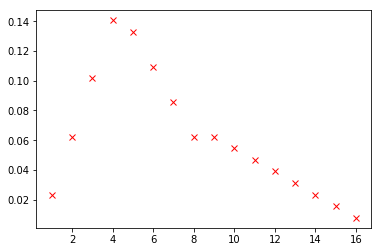

In [6]:
def save_half(dist,prob):
    new = Dist(dist*(1-prob))
    del new[0]
    for k,v in dist.items():
        new[k//2]+=v*prob
    return new
foo = save_half(2*d(8),psuccess(14,3))
foo.plot('rx')

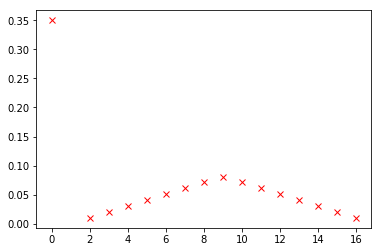

In [7]:
# This is what it looks like when save negates damage.
((2*d(8))*(.65)).plot('rx')

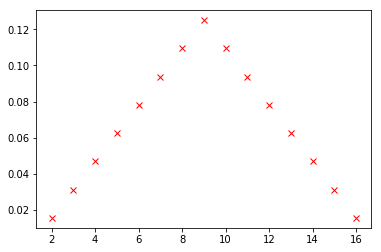

In [7]:
# By the way, this is what the plot method on these objects is basically doing.
thunderwave = 2*d(8)
plt.plot(thunderwave.keys(),thunderwave.values(),'rx')

Alright, now it's onto the original reason for this exercise: How much damage does a spore druid do on average? Here's an example (my character) with polearm master and shillelagh to turn that +4 wisdom into an attack stat.

For these purposes, we're looking at a level 5 character, for a +4 wis and +3 proficiency (+7 to hit) vs an AC of 14, which is around that of monsters at this level. The druid's spell save DC here is 15.

19.35

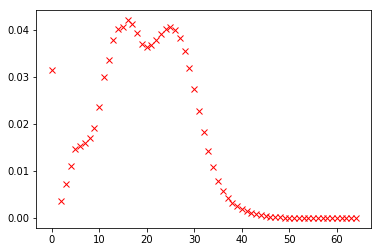

In [9]:
spore_shillelagh =( hit(d(8)+d(6),+4,14,+7)
    +hit(d(4)+d(6),+4,14,7)
    #save_half(2*d(10),psuccess(15,1))+\
    +(2*d(4))*pfail(15,1) )
spore_shillelagh.plot('rx')
float(spore_shillelagh.mean())

(15.425, 21.725)

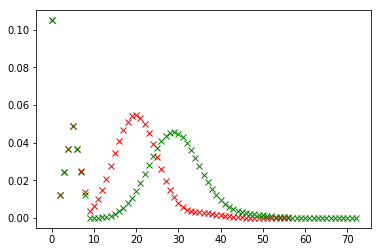

In [12]:
#assumes monster doesn't move
spore_boom =( hit(2*d(8)+d(6),+4,14,+7)
    +(2*d(4))*pfail(15,1) )
#moves
spore_boom_m =( hit(2*d(8)+d(6),+2*d(8)+4,14,+7)
    +(2*d(4))*pfail(15,1) )
#The 2d8 extra rider damage goes in the "flat" part not doubled by crits.
spore_boom.plot("rx")
spore_boom_m.plot("gx")
float(spore_boom.mean()),float(spore_boom_m.mean())

19.275

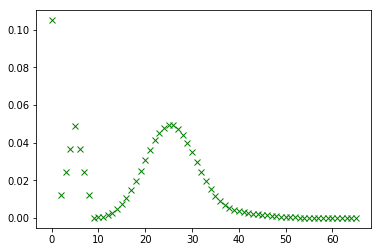

In [17]:
# With GFB, even at a +1 int it's on par with PAM as long as
# there's a second enemy nearby, and it leaves the bonus open!
#GFB has a regular on-hit component
# and a secondary component not doubled.
spore_green =( hit(2*d(8)+d(6),d(8)+4+1,14,+7)
    +(2*d(4))*pfail(15,1) )

spore_green.plot('gx')
float(spore_green.mean())

(24.9875, 21.725)

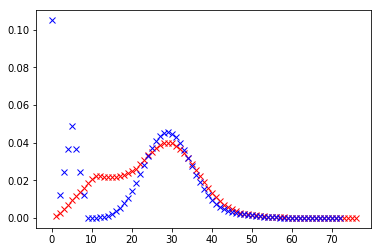

In [19]:
spore_boom_a = spore_boom+save_half(2*d(10),psuccess(15,-1)) #Doesn't move; takes moonbeam
spore_boom_a.plot("rx")
spore_boom_m.plot("bx") #moves, takes booming blade
float(spore_boom_a.mean()),float(spore_boom_m.mean())

As a side note from damage optimization, what's the average number of concentration checks that it'll take for a character to fail one? Let's assume the damage per hit is less than 22, so it'll just be a DC10 check every time.

This average is going to be over a geometric distribution, so it'll just be 1/(1-x), where x is the chance of success every time.

With a -11 'bonus', the character fails the first check. Average hits taken before concentration broken: 1

In [48]:
1/(1-float(psuccess(10,-11)))

1.0

With an ordinary low-level character's +2 to constitution (ability score 14 or 15) it doesn't look good.

In [49]:
1/(1-float(psuccess(10,2)))

2.857142857142857

Warcaster feat dramatically improves this to over 8.

In [50]:
1/(1-float(psuccess(10,2,advd)))

8.163265306122446

The resilient feat (constitution) adds a proficiency bonus, +3 at level 5, to the save. It helps a bit, but not as much.

In [51]:
1/(1-float(psuccess(10,5)))

5.000000000000001

Ok, now let's compare different options for barbarians, wielding different combinations of weapons and using frenzy for an extra attack or not. At level 5, a barbarian with...
 - A 2d6 greatsword gets two attacks.
 - With two 1d6 handaxes, we have two plus an extra bonus action off-hand attack without the strength bonus to damage
 - With two 1d8 battleaxes, using the dual wielder feat we can upgrade to two larger axes, used like above.
 - A frenzied berserker path barbarian can make an attack using their one main weapon as a bonus action.

In [20]:
gs_barb = 2*hit(2*d(6),+6,14,+7)
handaxes_barb = 2*hit(d(6),+6,14,7)+hit(d(6),+2,14,+7)
battleaxes_barb = 2*hit(d(8),+6,14,7)+hit(d(8),+2,14,7)
frenzy_barb = 3*hit(2*d(6),+6,14,7)

{'gs': 18.9, 'handaxes': 17.675, 'battleaxes': 19.925, 'frenzy': 28.35}

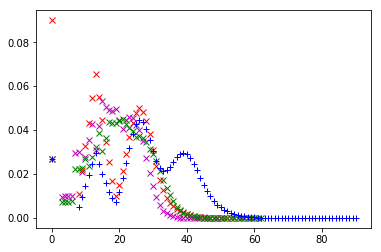

In [21]:
gs_barb.plot('rx')
handaxes_barb.plot('mx')
battleaxes_barb.plot('gx')
frenzy_barb.plot('b+')
barbs = {"gs":gs_barb,"handaxes":handaxes_barb,"battleaxes":battleaxes_barb,"frenzy":frenzy_barb}

{name:float(barb.mean()) for name,barb in barbs.items()}

Let's do a comparison of animals summoned by conjure animals, specifically the option for 8 CR 1/4 animals.

69.0

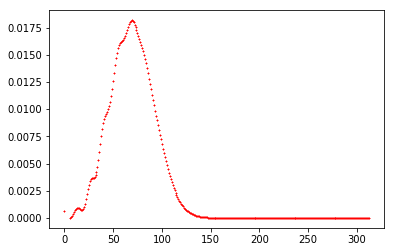

In [35]:
elks = 8*hit(3*d(6),+3,14,+5)
elks.plot('r+',markersize=2)
float(elks.mean())

34.8

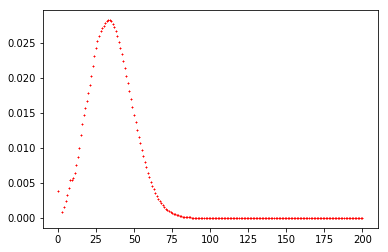

In [36]:
giant_owls = 8*hit(2*d(6),+1,14,+3)
giant_owls.plot('r+',markersize=2)
float(giant_owls.mean())

48.56

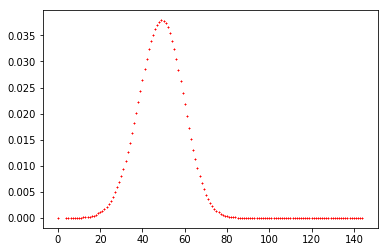

In [37]:
#wolves = 8*((2*d(4)+2)*psuccess(14,4,advd))
wolves = 8*hit(2*d(4),+2,14,+4,roll=advd)
wolves.plot('r+',markersize=2)
float(wolves.mean())

Wow, it looks like the elk do really well, even without factoring in that a prone enemy gives them advantage on attacks! With the fact that the target may fall over after the first few ramming attacks, their hit probability would look more like the wolves. That's even better!

98.91

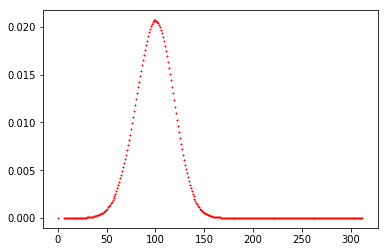

In [38]:
elks = 8*hit(3*d(6),+3,14,+5,roll=advd)
elks.plot('r+',markersize=2)
float(elks.mean())